In [202]:
%reload_ext autoreload

In [203]:
# Packages needed

#!pip install "tabulate" "pandas_summary" "imblearn" "joblib"
#!pip install fastai==0.7.0
#!pip install eli5

In [204]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline
import sys
import pandas as pd
from fastai.imports import *
from fastai.structured import *
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV

#import numpy as np
#import random
#from matplotlib import pyplot
#from pandas_summary import DataFrameSummary
#from IPython.display import display
#from tabulate import tabulate
#from sklearn.model_selection import GridSearchCV
#from scipy.stats.mstats import mode, gmean, hmean
#from sklearn import metrics

#set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [205]:
sys.path.append('../lib')
import utils
import preprocessing

In [206]:
# Load in data

PATH = "../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=['canceldate', 'licence_registration_date', 'golive_date'])

In [207]:
print(len(df_raw), df_raw.shape)
df_processed = preprocessing.prepare_data(df_raw.loc[df_raw.licence_status != "STAGING"])
print(len(df_processed), df_processed.shape)

5889 (5889, 38)


../lib/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['annual_revenue'][dataframe['annual_revenue'] == 0] = dataframe['annual_revenue'].median()
//anaconda2/envs/fastai-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
//anaconda2/envs/fastai-cpu/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


5547 (5547, 96)


In [208]:
df_filtered = df_processed.loc[df_processed.licence_registration_Year > 2015]

In [209]:
df_trn, y_trn, nas = proc_df(df_filtered, 'churned')
print(len(df_trn), df_trn.shape)

4074 (4074, 95)


//anaconda2/envs/fastai-cpu/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [210]:
def split_vals(a,n): return a[:n], a[n:]

n_valid = 500
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [211]:
X_train.shape, y_train.shape

((3574, 95), (3574,))

In [212]:
# Fix the dataset imbalance

sm = SMOTE(random_state=12, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [213]:
X_train_res.shape, y_train_res.shape

((4250, 95), (4250,))

In [214]:
# Show any features with NaN values
preprocessing.features_with_nan(df_processed)

In [215]:
X_train.shape, y_train.shape

((3574, 95), (3574,))

In [216]:
m = RandomForestClassifier(
    n_estimators=2000,
    min_samples_leaf=3, 
    max_features='sqrt',
    n_jobs=-1, 
    #oob_score=True,
    max_depth=3,
    bootstrap=False,
    criterion='entropy',
    class_weight={0: 4, 1: 1}
    )

m.fit(X_train_res, y_train_res)
#m.fit(X_train, y_train)

y_pred = m.predict(X_valid)
print(utils.uber_score(y_valid, y_pred))
utils.conf_matrix(y_valid, y_pred)

# Save to file in the current working directory
joblib_file = "churn_model.pkl"
joblib.dump(m, joblib_file)

0.4585987261146497 0.9536423841059603 0.6193548387096774 0.646 0.3571677610552618 0.354
None
tp, fn, fp, tn
[[179 170]
 [  7 144]]


['churn_model.pkl']

In [217]:
import eli5
eli5.explain_weights(m)

Weight,Feature
0.1666 ± 0.5698,x1
0.1500 ± 0.5472,x91
0.0513 ± 0.3107,x90
0.0507 ± 0.3129,x78
0.0501 ± 0.3126,x89
0.0466 ± 0.2942,x5
0.0447 ± 0.2967,x83
0.0390 ± 0.1920,x8
0.0345 ± 0.1715,x7
0.0338 ± 0.2603,x87


In [218]:
eli5.show_prediction(m)

TypeError: show_prediction() missing 1 required positional argument: 'doc'

In [219]:
fi = rf_feat_importance(m, X_valid); fi[:10]

,cols,imp
1,days_active,0.166564
91,days_active_log,0.149997
90,golive_Elapsed,0.051341
78,golive_Year,0.050739
89,golive_Is_year_start,0.050147
5,golive_days,0.046645
83,golive_Dayofyear,0.044673
8,cases_closed,0.039031
7,cases_open,0.034491
87,golive_Is_quarter_start,0.033803


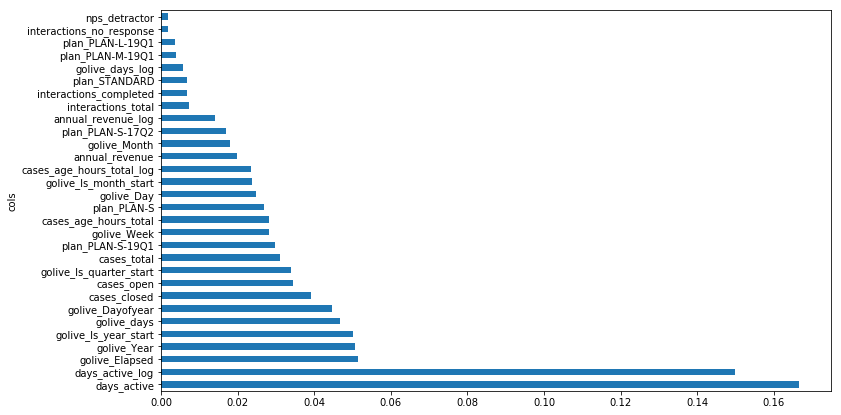

In [220]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [221]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [222]:
m = RandomForestClassifier(
    n_estimators=5000,
    min_samples_leaf=2, 
    max_features='sqrt',
    n_jobs=-1,
    max_depth=3,
    bootstrap=False,
    criterion='entropy',
    class_weight={0: 4, 1: 1}
    )

m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight={0: 4, 1: 1},
                       criterion='entropy', max_depth=3, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=5000, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [ ]:
utils.plot_roc_pr(m, X_valid, y_valid)

In [ ]:
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(10,10))
dendrogram = hc.dendrogram(z, labels=df_trn.columns, orientation='left', leaf_font_size=16)
plt.show()

In [ ]:
print("precision, recall, f1_score, accuracy, cohen_kappa_score, mean abs error")

for column in df_keep.columns:
    m = RandomForestClassifier(
        n_estimators=200,
        min_samples_leaf=2, 
        max_features='sqrt',
        n_jobs=-1, 
        max_depth=3,
        bootstrap=False,
        criterion='entropy',
        class_weight={0: 4, 1: 1}
        )

    x, _ = split_vals(df_keep.drop(columns=[column]), n_trn)
    m.fit(x, y_train)
    y_pred = m.predict(x)
    print(column, utils.uber_score(y_train, y_pred))